# 1. Test data process (xyz + uv + normal)

In [ ]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj

mesh_fp = '../resources/examples/objs/0000/0000.obj'
mesh_obj = read_obj(mesh_fp)

print('*** verts: ', mesh_obj.points.shape, mesh_obj.points.max(axis=0), mesh_obj.points.min(axis=0))
print('*** uvs: ', mesh_obj.point_data['obj:vt'].shape, mesh_obj.point_data['obj:vt'].max(axis=0), mesh_obj.point_data['obj:vt'].min(axis=0))
print('*** normals: ', mesh_obj.point_data['obj:vn'].shape, mesh_obj.point_data['obj:vn'].max(axis=0), mesh_obj.point_data['obj:vn'].min(axis=0))


## 1.1 Visualize Geometry && Edges

In [ ]:
import os
import random
import pickle
import open3d as o3d

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
from matplotlib.colors import to_rgb


from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#696969"},
    "木耳边": {"alias": "木耳边", "color": "#696969"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#696969"},
    "荷叶边": {"alias": "荷叶边", "color": "#696969"
            
            },
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r'):
    
    num_points = bboxes_min.shape[0]
    print(bboxes_min.shape, bboxes_max.shape, num_points)
    
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        
        width = x1 - x0
        height = y1 - y0
        
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x0, y0), width, height, linestyle='--', linewidth=1, 
            edgecolor=color, 
            facecolor='none')
        
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_reso_256\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))
# data_path = os.path.join(data_root, '7529.pkl')

with open(data_path, "rb") as tf: data = pickle.load(tf)

print([x for x in data['faceEdge_adj'].items()])

print(data['data_fp'], data['surf_cls'])
print(data['surf_wcs'].shape, data['global_offset'], data['global_scale'])
print(data['edge_wcs'].shape, data['edge_uv_wcs'].shape)
print('*** ncs: ', data['surf_ncs'].shape, data['surf_ncs'].min(), data['surf_ncs'].max())

print('*** edge_bbox', data['edge_bbox_wcs'].shape, data['edge_uv_bbox_wcs'].shape, data['edge_ncs'].shape, data['edge_uv_ncs'].shape)

global_offset = np.array(data['global_offset'])[None]
global_scale = data['global_scale']

uv_offset = data['uv_offset'][None]
uv_scale = data['uv_scale']

########## CHECK WCS ###########
# surf_pnts = data['surf_mask'].reshape(-1, 1) * (data['surf_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset)
# edge_pnts = data['edge_wcs'].reshape(-1, 3) * (global_scale * 0.5) + global_offset
# surf_uvs = data['surf_mask'].reshape(-1, 1) * (data['surf_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset)
# edge_uvs = data['edge_uv_wcs'].reshape(-1, 2) * (uv_scale * 0.5) + uv_offset
################################

########## CHECK NCS ###########
# Surface
bbox_scale = np.max(data['surf_bbox_wcs'][:, 3:] - data['surf_bbox_wcs'][:,:3], axis=1)[:, None, None, None]
bbox_offset = ((data['surf_bbox_wcs'][:, 3:] + data['surf_bbox_wcs'][:, :3]) * 0.5)[:, None, None, :]
surf_pnts_wcs = data['surf_mask'] * (data['surf_ncs'] * (bbox_scale * 0.5) + bbox_offset)
surf_pnts = data['surf_mask'].reshape(-1, 1) * (surf_pnts_wcs.reshape(-1, 3) * (global_scale * 0.5) + global_offset)

bbox_scale_uv = np.max(data['surf_uv_bbox_wcs'][:, 2:] - data['surf_uv_bbox_wcs'][:,:2], axis=1)[:, None, None, None]
bbox_offset_uv = ((data['surf_uv_bbox_wcs'][:, 2:] + data['surf_uv_bbox_wcs'][:, :2]) * 0.5)[:, None, None, :]
surf_uvs_wcs = data['surf_mask'] * (data['surf_uv_ncs'] * (bbox_scale_uv * 0.5) + bbox_offset_uv)
surf_uvs = data['surf_mask'].reshape(-1, 1) * (surf_uvs_wcs.reshape(-1, 2) * (uv_scale * 0.5) + uv_offset)
surf_masks = data['surf_mask'].reshape(-1).astype(bool)

# Edge
bbox_scale = np.max(data['edge_bbox_wcs'][:, 3:] - data['edge_bbox_wcs'][:,:3], axis=1)[:, None, None]
bbox_offset = ((data['edge_bbox_wcs'][:, 3:] + data['edge_bbox_wcs'][:, :3]) * 0.5)[:, None, :]
edge_pnts_wcs = data['edge_ncs'] * (bbox_scale * 0.5) + bbox_offset
edge_pnts = edge_pnts_wcs.reshape(-1, 3) * (global_scale * 0.5) + global_offset

bbox_scale_uv = np.max(data['edge_uv_bbox_wcs'][:, 2:] - data['edge_uv_bbox_wcs'][:,:2], axis=1)[:, None, None]
bbox_offset_uv = ((data['edge_uv_bbox_wcs'][:, 2:] + data['edge_uv_bbox_wcs'][:, :2]) * 0.5)[:, None, :]
edge_uvs_wcs = data['edge_uv_ncs'] * (bbox_scale_uv * 0.5) + bbox_offset_uv
edge_uvs = edge_uvs_wcs.reshape(-1, 2) * (uv_scale * 0.5) + uv_offset
################################

print('*** surf_pnts: ', surf_pnts.max(axis=0), surf_pnts.min(axis=0))
print('*** edge_pnts: ', edge_pnts.max(axis=0), edge_pnts.min(axis=0))
print('*** uv_offset: ', uv_offset.shape, uv_offset.max(axis=0), uv_offset.min(axis=0))


surf_colors = ((data['surf_normals'].reshape(-1, 3) + 1.0) * 0.5).clip(0, 1)
edge_colors = np.expand_dims(np.random.rand(data['edge_uv_wcs'].shape[0], 3), axis=1).repeat(data['edge_uv_wcs'].shape[1], axis=1).reshape(-1, 3)

surf_pcd = _to_o3d_pc(surf_pnts[surf_masks, :], surf_colors[surf_masks, :])
edge_pcd = _to_o3d_pc(edge_pnts, edge_colors)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.scatter(surf_uvs[surf_masks, 0], surf_uvs[surf_masks, 1], c=surf_colors[surf_masks, :], s=3.5)
ax.scatter(edge_uvs[:, 0], edge_uvs[:, 1], c=edge_colors, s=5)
ax.scatter(edge_uvs[:, 0], edge_uvs[:, 1], c=edge_colors, s=5)

surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2] * (uv_scale * 0.5) + uv_offset
surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:] * (uv_scale * 0.5) + uv_offset
surf_color = np.random.rand(len(surf_uv_bbox_min), 3)
print('*** surf_color: ', surf_uv_bbox_max.shape, surf_color.shape)
_draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, color=np.random.rand(3))

print('*** edge uv bbox: ', data['edge_uv_bbox_wcs'].shape)
edge_uv_bbox_min = data['edge_uv_bbox_wcs'][:, :2] * (uv_scale * 0.5) + uv_offset
edge_uv_bbox_max = data['edge_uv_bbox_wcs'][:, 2:] * (uv_scale * 0.5) + uv_offset
# _draw_bboxes_2d(ax, edge_uv_bbox_min, edge_uv_bbox_max, color=surf_color)

# plt.axis('off')
plt.axis('equal')
plt.show()

surf_bboxes_3d = []
surf_bbox_min = data['surf_bbox_wcs'][:, :3] * (global_scale * 0.5) + global_offset
surf_bbox_max = data['surf_bbox_wcs'][:, 3:] * (global_scale * 0.5) + global_offset
for idx in range(surf_bbox_min.shape[0]):
    _surf_bboxes_3d = o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx], surf_bbox_max[idx])
    _surf_bboxes_3d.color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])
    _surf_bbox_lines = _surf_bboxes_3d.LineSet
    
    print(_surf_bbox_lines)
    o3d.visualization.draw_geometries([lines], line_width=5)
    
    surf_bboxes_3d.append(o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx][..., None], surf_bbox_max[idx][..., None]))
    surf_bboxes_3d[-1].color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([surf_pcd, edge_pcd, mesh_frame] + surf_bboxes_3d)

[(0, [0, 1, 2, 3]), (1, [4, 5, 6, 7, 8, 9, 10]), (2, [11, 12, 13, 14, 15, 16, 17]), (3, [18, 19, 20, 21]), (4, [22, 23, 24, 25]), (5, [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]), (6, [39, 40, 41, 42]), (7, [43, 44, 45, 46]), (8, [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]), (9, [57, 58, 59, 60, 61, 62, 63, 64, 65, 66]), (10, [67, 68, 69, 70, 71, 72, 73, 74, 75]), (11, [76, 77, 78, 79, 80, 81])]
\\192.168.29.222\Share\工程数据Q1\objs\仅工程类\0304\张雪\V领泡泡袖腰部抽褶叠门襟连衣裙 [ 6  6  6  6  7  7  5  5  4  4 11 12]
(12, 256, 256, 3) [   0. 1000.    0.] 1000.0
(82, 16, 3) (82, 16, 2)
*** ncs:  (12, 256, 256, 3) -1.0 1.0
*** edge_bbox (82, 6) (82, 4) (82, 16, 3) (82, 16, 2)
*** surf_pnts:  [ 447.28024 1506.7004   207.59497] [-445.69913    0.      -193.60336]
*** edge_pnts:  [ 447.3503  1506.7179   207.48401] [-445.76526  333.33203 -193.38283]
*** uv_offset:  (1, 2) [   0. 1000.] [   0. 1000.]
[_to_o3d_pc] color:  std::vector<Eigen::Vector3d> with 631177 elements.
Use numpy.asarray() to access data.
[_

Type.LineSet
Type.LineSet
Type.LineSet
Type.LineSet
Type.LineSet
Type.LineSet
Type.LineSet
Type.LineSet
Type.LineSet
Type.LineSet
Type.LineSet
Type.LineSet


## 1.2 Visualize Surface Points (check mask)

In [ ]:
import os
import numpy as np
import pickle
import random
from glob import glob
from matplotlib import pyplot as plt
import math

plt.rcParams['font.sans-serif']=['SimHei'] # Show Chinese label
plt.rcParams['axes.unicode_minus']=False   # These two lines need to be set manually

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']
    
data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data['data_fp'])

num_panels = data['surf_wcs'].shape[0]

n_cols = 8
n_rows = math.ceil(num_panels / n_cols)
print(num_panels, n_cols, n_rows)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20/n_cols*n_rows))

for idx in range(num_panels):   
    # img_arr = data['surf_wcs'][idx]
    img_arr = data['surf_mask'][idx] * (data['surf_wcs'][idx] + 1.0) * 0.5
    x_idx = idx // n_cols
    y_idx = idx % n_cols     
    axs[x_idx, y_idx].set_title(_PANEL_CLS[data['surf_cls'][idx]-1])
    axs[x_idx, y_idx].imshow(np.clip(img_arr[::-1, :, :], 0., 1.).astype(np.float32))

plt.show()

## 1.3 Visualize 2D Bounding Boxes

In [ ]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 
from matplotlib.colors import to_rgb

from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#DACBBD"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#DACBBD"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']

def _draw_bboxes_2d(ax, bboxes_min, bboxes_max, color='r', cmap=None):
    num_points = bboxes_min.shape[0]
    for idx in range(num_points):
        p0_ = bboxes_min[idx]
        p1_ = bboxes_max[idx]
        
        # Extract coordinates
        
        x0, y0 = p0_
        x1, y1 = p1_
        
        # Calculate width and height of the bounding box
        width = x1 - x0
        height = y1 - y0
        # Create a rectangle patch
        rect = patches.Rectangle(
            (x0, y0), width, height, linestyle='--', linewidth=1, 
            edgecolor=color if cmap is None else cmap[idx], facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
        

data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
all_items = random.choices(glob(os.path.join(data_root, '*.pkl')), k=100)

print('*** all_items: ', len(all_items), all_items)

surf_uv_bboxes = []

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

x_min, y_min, x_max, y_max = np.inf, np.inf, -np.inf, -np.inf

for data_item in all_items:
    with open(data_item, "rb") as tf: data = pickle.load(tf)
    
    uv_scale = data['uv_scale']
    uv_offset = data['uv_offset']
    
    # print(uv_scale, uv_offset)
    
    # surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2]
    # surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:]

    surf_uv_bbox_min = data['surf_uv_bbox_wcs'][:, :2] * uv_scale * 0.5 + uv_offset
    surf_uv_bbox_max = data['surf_uv_bbox_wcs'][:, 2:] * uv_scale * 0.5 + uv_offset
    
    if surf_uv_bbox_max[0].max() > x_max: x_max = surf_uv_bbox_max[0].max()
    if surf_uv_bbox_max[1].max() > y_max: y_max = surf_uv_bbox_max[1].max()
    if surf_uv_bbox_min[0].min() < x_min: x_min = surf_uv_bbox_min[0].min()
    if surf_uv_bbox_min[1].min() < y_min: y_min = surf_uv_bbox_min[1].min()
    
    surf_color = np.asarray([to_rgb(_CMAP[_PANEL_CLS[x-1]]['color']) for x in data['surf_cls']])
    _draw_bboxes_2d(ax, surf_uv_bbox_min, surf_uv_bbox_max, cmap=surf_color)    

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

## 1.4 Visualize Bounding Box 3D

In [ ]:
import os
import random
import pickle
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches 

from glob import glob

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#DACBBD"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#DACBBD"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带'
    ]
        

data_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_uni_norm\\"
all_items = random.choices(glob(os.path.join(data_root, '*.pkl')), k=100)

print('*** all_items: ', len(all_items), all_items)

surf_bboxes = []

for data_item in all_items:
    with open(data_item, "rb") as tf: data = pickle.load(tf)
    
    global_scale = data['global_scale']
    global_offset = data['global_offset']
    
    
    # print(uv_scale, uv_offset)
    
    surf_bbox_min = data['surf_bbox_wcs'][:, :3]
    surf_bbox_max = data['surf_bbox_wcs'][:, 3:]
    
    # surf_bbox_min = data['surf_bbox_wcs'][:, :3] * global_scale * 0.5 + global_offset
    # surf_bbox_max = data['surf_bbox_wcs'][:, 3:] * global_scale * 0.5 + global_offset
    
    for idx in range(surf_bbox_min.shape[0]):
        surf_bbox = o3d.geometry.AxisAlignedBoundingBox(surf_bbox_min[idx][..., None], surf_bbox_max[idx][..., None])
        surf_bbox.color = to_rgb(_CMAP[_PANEL_CLS[data['surf_cls'][idx]-1]]['color'])
        surf_bboxes.append(surf_bbox)

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([mesh_frame] + surf_bboxes)

## 1.5 Test extract polygon from surf UV points

In [ ]:
import os
import random
import pickle
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull

import torch
import torch.nn.functional as F

from shapely.geometry import MultiPoint, Polygon
from shapely.ops import unary_union, polygonize
from scipy.spatial import Delaunay

import open3d as o3d

from skimage import measure
from skimage.feature import corner_harris, corner_subpix, corner_peaks

from glob import glob

_PAD_SIZE = 1


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd


def calculate_curvature(points, shift=1.0):
    vec1 = points - np.roll(points, shift, axis=0)
    vec2 = np.roll(points, -shift, axis=0) - points
    
    vec1 = vec1 / (np.linalg.norm(vec1, axis=1)[:, None] + 1e-6)
    vec2 = vec2 / (np.linalg.norm(vec2, axis=1)[:, None] + 1e-6)
    
    angles = np.arccos(np.sum(vec1 * vec2, axis=-1))      
    angles = angles / np.pi * 180
    
    return angles


def snap_coordinate(points, conf_mat):
    coord_x = points[:, 0]
    coord_y = points[:, 1]

    right = np.ceil(coord_x).astype(int)
    left = np.floor(coord_x).astype(int)
    top = np.ceil(coord_y).astype(int)
    bottom = np.floor(coord_y).astype(int)

    corner_conf_mat = np.stack([
        conf_mat[bottom, left], 
        conf_mat[bottom, right], 
        conf_mat[top, left], 
        conf_mat[top, right]], 
        axis=-1)

data_root = "/data/lry/data/AIGP/demo_v2/Q2/brep_uni_norm"
# data_path = random.choice(glob(os.path.join(data_root, '*.pkl')))
data_path = os.path.join(data_root, '1975.pkl')

with open(data_path, "rb") as tf: data = pickle.load(tf)

print(data.keys())

data['surf_mask'] = data['new_surf_mask']
data['surf_uv_wcs'] = data['new_surf_uv_wcs']

uv_offset = data['uv_offset'][None]
uv_scale = data['uv_scale']

edge_3d_pts = []
corner_3d_pts = []

# fig, ax = plt.subplots(figsize=(20, 20))

for panel_idx in range(data['surf_uv_wcs'].shape[0]):
        
    cur_mask = data['surf_mask'][panel_idx, :, :, 0].astype(float)
    print('*** cur_mask: ', cur_mask.shape, cur_mask.min(), cur_mask.max())

    cur_mask = F.sigmoid(torch.tensor(cur_mask)).numpy()
    print('*** cur_mask_prob: ', cur_mask.shape, cur_mask.min(), cur_mask.max())
    
    panel_color = np.random.rand(3)
    
    H, W = data['surf_mask'].shape[1:3]
    print(H, W)

    # Find contours at a constant value of 0.5
    padded_mask = np.zeros((cur_mask.shape[0] + 2 * _PAD_SIZE, cur_mask.shape[1] + 2 * _PAD_SIZE))
    padded_mask[_PAD_SIZE:-_PAD_SIZE, _PAD_SIZE:-_PAD_SIZE] = cur_mask
    
    contours = measure.find_contours(padded_mask, 0.999)[0]
    corner_coords = corner_peaks(corner_harris(padded_mask), min_distance=3, threshold_rel=0.01)

    corner_contour_dist = np.linalg.norm(corner_coords[:, None] - contours[None], axis=-1)
    corner_contour_idx = np.argmin(corner_contour_dist, axis=1)
    
    print('*** contours: ', contours.shape, contours.min(axis=0), contours.max(axis=0))
    boundary_index = np.round(contours-_PAD_SIZE).astype(int)
    corner_index = boundary_index[corner_contour_idx, :]
        
    boundary_index[:, 0] = np.clip(boundary_index[:, 0] + _PAD_SIZE, 0, H-1+2*_PAD_SIZE)
    boundary_index[:, 1] = np.clip(boundary_index[:, 1] + _PAD_SIZE, 0, W-1+2*_PAD_SIZE)
    corner_index[:, 0] = np.clip(corner_index[:, 0], 0, H-1+2*_PAD_SIZE)
    corner_index[:, 1] = np.clip(corner_index[:, 1], 0, W-1+2*_PAD_SIZE)

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(padded_mask, cmap='gray')
    ax.plot(contours[:, 1], contours[:, 0], linewidth=2)
    ax.scatter(boundary_index[:, 1], boundary_index[:, 0], s=5.0, c='r')
        
    ax.plot(
        corner_coords[:, 1], corner_coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=15
    )
    
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
        
    # break
    
#     # Extract 2D coordinate of boundary points
#     cur_panel_uvs = data['surf_uv_wcs'][panel_idx]
#     boundary_uvs = cur_panel_uvs[boundary_index[:, 0], boundary_index[:, 1]]
#     boundary_uvs = boundary_uvs * (uv_scale * 0.5) + uv_offset
#     ax.plot(boundary_uvs[:, 0], boundary_uvs[:, 1], linewidth=2, c=panel_color)

#     corner_uvs = cur_panel_uvs[corner_index[:, 0], corner_index[:, 1]]
#     corner_uvs = corner_uvs * (uv_scale * 0.5) + uv_offset
#     ax.scatter(corner_uvs[:, 0], corner_uvs[:, 1], c='r', s=20)
            
#     cur_panel_pts = data['surf_wcs'][panel_idx]
#     boundary_pts = cur_panel_pts[boundary_index[:, 0].astype(int), boundary_index[:, 1].astype(int)]
#     boundary_pts = boundary_pts * (data['global_scale'] * 0.5) + data['global_offset']
#     boundary_pts = _to_o3d_pc(boundary_pts, color=panel_color)
#     edge_3d_pts.append(boundary_pts)
    
#     corner_pts = cur_panel_pts[corner_index[:, 0], corner_index[:, 1]]
#     corner_pts = corner_pts * (data['global_scale'] * 0.5) + data['global_offset']
#     if corner_pts.shape[0] > 0:
#         corner_pts = _to_o3d_pc(corner_pts, color=np.array([1., 0., 0.]))
#         corner_3d_pts.append(corner_pts)

# ax.axis('equal')
# ax.axis('off')
# plt.show()

# mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0., 0., 0.])
# o3d.visualization.draw_geometries([mesh_frame] + edge_3d_pts + corner_3d_pts)

# 2. Data Validation

## 2.1 Validate Panel Data

Validate sewing pattern statistics, e.g. number of panels per garment, number of edges per panel etc. Skip too complicate garments.

In [ ]:

import os
import json
from glob import glob
from tqdm import tqdm
import numpy as np
import shutil

from matplotlib import pyplot as plt

_MAX_NUM_PANELS = 32
_MAX_NUM_EDGES = 40

data_roots = [
    "\\\\192.168.29.222\\Share\\工程数据Q1\\objs", 
    "\\\\192.168.29.222\\Share\\工程数据Q2_objs"
    ]
all_items = []

print(">>> Locating data items...")
for data_root in data_roots:
    cur_items = glob(os.path.join(data_root, '**', 'pattern.json'), recursive=True)
    all_items += cur_items
    print("%d items in %s."%(len(cur_items), data_root))

num_panels = []
num_edges = []
    
invalid_other = []
invalid_wrong_panel_name = []
invalid_too_many_edges = []
invalid_too_many_panels = []
    
_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']
    
print(">>> Validating data items...")
for data_fp in tqdm(all_items):
    try:        
        with open(data_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)
        n_panels = len(pattern_spec['panels'])
        if n_panels > _MAX_NUM_PANELS:
            invalid_too_many_panels.append((data_fp, n_panels))
            print('[TOO_MANY_PANELS] %s: %d'%(data_fp, n_panels))
        
        num_panels.append(n_panels)
        for panel in pattern_spec['panels']:
            if panel['label'].strip().split()[0].split('_')[0] not in _PANEL_CLS:
                invalid_wrong_panel_name.append((data_fp, panel['id'], panel['label']))
                print('\t [WRONG_PANEL_LABEL] %s: %s - %s'%(data_fp, panel['id'], panel['label']))
            n_edges = sum([len(x['edges']) for x in panel['seqEdges'] if x['type'] == 3])
            if n_edges > _MAX_NUM_EDGES:
                invalid_too_many_edges.append((data_fp, panel['id'], n_edges))
                print('\t [TOO_MANY_EDGES] %s: %s - %d'%(data_fp, panel['id'], n_edges))
            num_edges.append(n_edges)
        
    except Exception as e:
        invalid_other.append(data_fp)
        print('Error in %s: %s'%(data_fp, e))
        continue
            
print('>>> Summary: ')
print('\t num_panels: min=%d; max=%d;, avg=%.4f'%(min(num_panels), max(num_panels), np.mean(num_panels)))
print('\t num_edges: min=%d; max=%d;, avg=%.4f'%(min(num_edges), max(num_edges), np.mean(num_edges)))

plt.hist(np.asarray(num_panels), bins=range(0, 100, 1))
plt.show()

plt.hist(np.asarray(num_edges), bins=range(0, 50, 1))
plt.show()

# # move invalid items to seperate folder
# print(">>> Moving invalid items to seperate directory...")
# invalid_items_total = invalid_other + [x[0] for x in invalid_wrong_panel_name] + [x[0] for x in invalid_too_many_edges] + [x[0] for x in invalid_too_many_panels]
# invalid_items_total = set([os.path.dirname(x) for x in invalid_items_total])
# for src_item in tqdm(invalid_items_total):
#     dst_item = src_item.replace("objs", "invalid")
#     os.makedirs(os.path.dirname(dst_item), exist_ok=True)
#     try:
#         shutil.move(src_item, dst_item)
#     except Exception as e:
#         print("\t Failed to move %s to %s"%(src_item, dst_item))


# ############## Logging to file ##############
# log_fp = "error_log.txt"
# print(">>> Logging invalid items to %s..."%(log_fp))
# with open(log_fp, 'w') as f:
#     f.write(">>> INVALID: \n")
#     for item in invalid_other:
#         f.write("\t %s\n"%os.path.dirname(item).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'))
#     f.write("\n")
#     f.write(">>> WRONG_PANEL_LABEL: \n")
#     for item in invalid_wrong_panel_name:
#         f.write("\t %s\n"%os.path.dirname(item[0]).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'))
#     f.write(">>> TOO_MANY_EDGES: \n")
#     for item in invalid_too_many_edges:
#         f.write("\t %s \t (edge_id: %s, num_edges: %d)\n"%(
#             os.path.dirname(item[0]).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'),
#             item[1], item[2]
#             ))
#     f.write(">>> TOO_MANY_PANELS: \n")
#     for item in invalid_too_many_panels:
#         f.write("\t %s \t (num_panels: %d)\n"%(os.path.dirname(item[0]).replace('工程数据Q1\objs', '工程数据Q1\sprojs').replace('工程数据Q2_objs', '工程数据Q2'), item[1]))

In [ ]:
# convert obj to point cloud
import os
import sys

import json

from glob import glob
from tqdm import tqdm

import numpy as np

sys.path.insert(0, os.path.abspath('..'))

from data_process.geometry_utils.obj import read_obj
from matplotlib.colors import to_rgb

_CMAP = {
    "帽": {"alias": "hat", "color": "#F7815D"},
    "领": {"alias": "collar", "color": "#F9D26D"},
    "肩": {"alias": "shoulder", "color": "#F23434"},
    "袖片": {"alias": "sleeve", "color": "#C4DBBE"},
    "袖口": {"alias": "cuff", "color": "#F0EDA8"},
    "衣身前中": {"alias": "body front", "color": "#8CA740"},
    "衣身后中": {"alias": "body back", "color": "#4087A7"},
    "衣身侧": {"alias": "body side", "color": "#DF7D7E"},
    "底摆": {"alias": "hem", "color": "#DACBBD"},
    "腰头": {"alias": "belt", "color": "#DABDD1"},
    
    "裙前中": {"alias": "skirt front", "color": "#46B974"},
    "裙后中": {"alias": "skirt back", "color": "#6B68F5"},
    "裙侧": {"alias": "skirt side", "color": "#D37F50"},
    
    "裤前中": {"alias": "pelvis front", "color": "#46B974"},
    "裤后中": {"alias": "pelvis back", "color": "#6B68F5"},
    "裤侧": {"alias": "pelvis side", "color": "#D37F50"},

    "橡筋": {"alias":"ruffles", "color": "#A8D4D2"},
    "木耳边": {"alias":"ruffles", "color": "#A8D4D2"},
    "袖笼拼条": {"alias":"ruffles", "color": "#A8D4D2"},
    "荷叶边": {"alias":"ruffles", "color": "#A8D4D2"},
    "绑带": {"alias":"ruffles", "color": "#A8D4D2"}
}

_GLOBAL_SCALE = 1000.0


data_roots = [
    "\\\\192.168.29.222\\Share\\工程数据Q1\\objs", 
    "\\\\192.168.29.222\\Share\\工程数据Q2_objs"
    ]
all_items = []

print(">>> Locating data items...")
for data_root in data_roots:
    cur_items = glob(os.path.join(data_root, '**', 'pattern.json'), recursive=True)
    all_items += cur_items
    print("%d items in %s."%(len(cur_items), data_root))
    
print(len(all_items))

pc_output_root = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\pointclouds"
all_data_dirs = [os.path.dirname(x) for x in all_items]

for idx, data_dir in enumerate(all_data_dirs):
    output_dir = os.path.join(pc_output_root, 'garment_%05d'%idx)
    os.makedirs(output_dir, exist_ok=True)
    
    obj_fp = os.path.join(data_dir, os.path.basename(data_dir)+'.obj')
    pattern_fp = os.path.join(data_dir, 'pattern.json')
    
    with open(pattern_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)
    
    out_panel_names = dict([(
        x['id'], 
        _CMAP[x['label'].split('|')[0].strip()]['alias'].replace(' ', '')+'_'+x['id'].split('-')[0]) \
        for x in pattern_spec['panels']])
    
    out_panel_names_sorted = {}
    for out_item in sorted(out_panel_names.values()):
        panel_cls, panel_id = out_item.split('_')
        if panel_cls not in out_panel_names_sorted: out_panel_names_sorted[panel_cls] = []
        out_panel_names_sorted[panel_cls].append(panel_id)
        
    for out_item in out_panel_names:
        panel_cls, panel_id = out_panel_names[out_item].split('_')
        panel_idx = out_panel_names_sorted[panel_cls].index(panel_id)
        out_panel_names[out_item] = '%s_%d'%(panel_cls, panel_idx+1)
        
    mesh_obj = read_obj(obj_fp)
    
    verts = mesh_obj.points
    normals = mesh_obj.point_data['obj:vn']
    uv = mesh_obj.point_data['obj:vt']
    
    for idx, panel_id in enumerate(mesh_obj.field_data['obj:group_tags']):
        if panel_id not in out_panel_names: continue
        
        panel_faces = mesh_obj.cells[idx].data        
        panel_verts_idx = np.unique(panel_faces.flatten())
        
        panel_verts = verts[panel_verts_idx, :] / _GLOBAL_SCALE
        panel_normals = normals[panel_verts_idx, :]
        panel_uvs = uv[panel_verts_idx, :2] / _GLOBAL_SCALE     # global uv
        
        panel_output = np.concatenate([panel_verts, panel_normals, panel_uvs], axis=1)
        panel_out_fp = os.path.join(output_dir, out_panel_names[panel_id]+'.txt')
    
        with open(panel_out_fp, 'w') as f:
            f.writelines('# x y z nx ny nz u v\n')
            np.savetxt(f, panel_output, fmt='%.6f')

In [ ]:
# visualize point cloud

import os

import numpy as np

import open3d as o3d
from matplotlib.colors import to_rgb

_CMAP = {
    "帽": {"alias": "hat", "color": "#F7815D"},
    "领": {"alias": "collar", "color": "#F9D26D"},
    "肩": {"alias": "shoulder", "color": "#F23434"},
    "袖片": {"alias": "sleeve", "color": "#C4DBBE"},
    "袖口": {"alias": "cuff", "color": "#F0EDA8"},
    "衣身前中": {"alias": "body front", "color": "#8CA740"},
    "衣身后中": {"alias": "body back", "color": "#4087A7"},
    "衣身侧": {"alias": "body side", "color": "#DF7D7E"},
    "底摆": {"alias": "hem", "color": "#DACBBD"},
    "腰头": {"alias": "belt", "color": "#DABDD1"},
    
    "裙前中": {"alias": "skirt front", "color": "#46B974"},
    "裙后中": {"alias": "skirt back", "color": "#6B68F5"},
    "裙侧": {"alias": "skirt side", "color": "#D37F50"},
    
    "裤前中": {"alias": "pelvis front", "color": "#46B974"},
    "裤后中": {"alias": "pelvis back", "color": "#6B68F5"},
    "裤侧": {"alias": "pelvis side", "color": "#D37F50"},

    "橡筋": {"alias":"ruffles", "color": "#A8D4D2"},
    "木耳边": {"alias":"ruffles", "color": "#A8D4D2"},
    "袖笼拼条": {"alias":"ruffles", "color": "#A8D4D2"},
    "荷叶边": {"alias":"ruffles", "color": "#A8D4D2"},
    "绑带": {"alias":"ruffles", "color": "#A8D4D2"}
}


_CMAP = dict([(_CMAP[x]['alias'].replace(' ', ''), to_rgb(_CMAP[x]['color'])) for x in _CMAP])
print(_CMAP)

def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

data_dir = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\pointclouds\\garment_00000"

panel_points = []
for panel_fp in os.listdir(data_dir):
    panel_cls = panel_fp.split('_')[0]
    panel_color = _CMAP[panel_cls]
    
    panel_pts = np.loadtxt(os.path.join(data_dir, panel_fp))
    panel_points.append(_to_o3d_pc(panel_pts[:, :3], color=panel_color))

o3d.visualization.draw_geometries(panel_points)

# 3. Experimental Scripts

Experimental Scripts.

## 3.1 Test SDF pattern (&& contour Finding)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi : np.pi : 100j, -np.pi : np.pi : 100j]
r = np.sin(np.exp(np.sin(x) ** 3 + np.cos(y) ** 2))

print(r.shape, r.max(), r.min())    # (-1.0, 1.0)

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
import numpy as np

def calculate_curvature(points):
    vec1 = points - np.roll(points, 1, axis=0)
    vec2 = np.roll(points, -1, axis=0) - points
    
    vec1 = vec1 / np.linalg.norm(vec1, axis=1)[:, None]
    vec2 = vec2 / np.linalg.norm(vec2, axis=1)[:, None]
    
    angles = np.arccos(np.sum(vec1 * vec2, axis=-1))      
    angles = angles / np.pi * 180
    
    return angles

pts = np.array([[0, 0], [1, 1], [2, 1], [3, 0], [1.5, -1.5]])
angles = calculate_curvature(pts)
print(angles)
print(np.where(angles > 75))

## 3.2 Test render vertice class labels.

Total items:  1206
(50753,) (50753,) uint8
[3 2 2 2 2 2 2 2 2 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-174.83238..1504.9291].


*** tri_ranges:  torch.Size([5, 2])
(5, 256, 256, 3) (5, 256, 256, 1) -427.1884 1520.3514 0 115


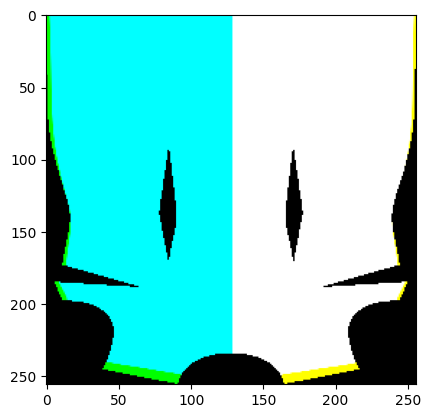

In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'


import sys
import random
from glob import glob

import json

import numpy as np
import torch
import nvdiffrast.torch as dr

PROJ_ROOT = os.path.abspath('..')
sys.path.insert(0, PROJ_ROOT)
sys.path.insert(0, os.path.join(PROJ_ROOT, 'data_process'))

from geometry_utils.obj import read_obj
from process_sxd import _get_vert_cls, _interpolate_feature_dr
from matplotlib import pyplot as plt

_RESO = 256

_POINT_CMAP = np.array([
    [0., 0., 0.],       # 0: background points
    [0.33, 0.33, 0.33], # 1: surface points
    [1.0, 0., 0.],      # 2: edge points 
    [0., 1., 0.]        # 3: corner points
])

data_roots = "\\\\192.168.29.222\\Share\\工程数据Q1\\objs"
all_objs = glob(os.path.join(data_roots, '**', '*.obj'), recursive=True)
print('Total items: ', len(all_objs))

data_fp = os.path.dirname(random.choice(all_objs))

mesh_obj = read_obj(os.path.join(data_fp, os.path.basename(data_fp)+'.obj'))
with open(os.path.join(data_fp, 'pattern.json'), 'r', encoding='utf-8') as f: pattern_spec = json.load(f)

vert_cls = _get_vert_cls(mesh_obj, pattern_spec)
print(mesh_obj.point_data['obj:cls'].shape, vert_cls.shape, vert_cls.dtype)
print(mesh_obj.point_data['obj:cls'][:10])

# verts = mesh_obj.points
# uv = mesh_obj.point_data['obj:vt']

# print('*** verts: ', verts.shape, uv.shape, vert_cls.shape)

# ############# test get_cls [OK] #############

# fig = plt.figure(figsize=(20, 20))
# interior_pts_uv = uv[vert_cls==1, :]
# # print("*** interior_pts_uv: ", interior_pts_uv.shape, type(interior_pts_uv))
# plt.scatter(interior_pts_uv[:, 0], interior_pts_uv[:, 1], c='grey', s=1.0)
# edge_pts_uv = uv[vert_cls==2, :]
# plt.scatter(edge_pts_uv[:, 0], edge_pts_uv[:, 1], c='r', s=5.0)
# corner_pts_uv = uv[vert_cls==3, :]
# plt.scatter(corner_pts_uv[:, 0], corner_pts_uv[:, 1], c='g', s=5.0)

# plt.axis('off')
# plt.show()

############# test rendering #################
glctx = dr.RasterizeCudaContext()

verts = torch.from_numpy(mesh_obj.points).to(torch.float32).to('cuda')
uv = torch.from_numpy(mesh_obj.point_data['obj:vt']).to(torch.float32).to('cuda')
normals = torch.from_numpy(mesh_obj.point_data['obj:vn']).to(torch.float32).to('cuda')
vert_cls = torch.from_numpy(mesh_obj.point_data['obj:cls']).to(torch.float32).to('cuda')

panel_data = dict([(x['id'], x) for x in pattern_spec['panels']])

panel_ids = []
panel_cls = []

uv_local = uv.clone()               # projected pixel coordinate for each vertex

tris = []                           # all triangles
tri_ranges = []                     # triangle range for each panel,
start_idx = 0

for idx, panel_idx in enumerate(mesh_obj.field_data['obj:group_tags']):    
    
    panel_faces = mesh_obj.cells[idx].data
    panel_verts_idx = np.unique(panel_faces.flatten())
    
    tris.append(torch.from_numpy(panel_faces).to('cuda'))
    tri_ranges.append([start_idx, len(panel_faces)])
    start_idx += len(panel_faces)
    
    panel_bbox2d = torch.cat([
        torch.min(uv_local[panel_verts_idx, :], dim=0, keepdim=True)[0],
        torch.max(uv_local[panel_verts_idx, :], dim=0, keepdim=True)[0]
    ])

    uv_local[panel_verts_idx, :] = (uv_local[panel_verts_idx, :] - panel_bbox2d[0]) / (
        panel_bbox2d[1] - panel_bbox2d[0] + 1e-6)      # normalize to [0, 1]
    
tris = torch.cat(tris, dim=0).to(torch.int32)
tri_ranges = torch.tensor(tri_ranges, dtype=torch.int32)
print('*** tri_ranges: ', tri_ranges.shape)   

uv_local = uv_local[..., :2] * 2.0 - 1.0
uv_local = torch.cat([
    uv_local,
    torch.zeros_like(uv_local[:, :1]),
    torch.ones_like(uv_local[:, :1])], dim=1)

rast, _ = dr.rasterize(
    glctx, uv_local, tris, 
    resolution=[_RESO, _RESO], 
    ranges=tri_ranges)

surf_pnts = _interpolate_feature_dr(rast, uv_local, tris, verts)
surf_cls = _interpolate_feature_dr(rast, uv_local, tris, vert_cls[:, None] * 40, antialias=True).astype(np.int32)

print(surf_pnts.shape, surf_cls.shape, surf_pnts.min(), surf_pnts.max(), surf_cls.min(), surf_cls.max())
    
for surf_idx in range(surf_cls.shape[0]):
    plt.imshow(surf_pnts[surf_idx])
    # colored_surf_cls = _POINT_CMAP[surf_cls[surf_idx].flatten(), :].reshape(_RESO, _RESO, 3)
    # plt.imshow(colored_surf_cls)
    plt.show()
    break


## 3.3 Test Triangulation

### 3.3.1 Grid Triangulation

In [ ]:
import os
import pickle

import numpy as np
import scipy
import einops
import skimage

from matplotlib import pyplot as plt

import open3d as o3d


def _pad_arr(arr, pad_size=10):
    return np.pad(
        arr, 
        ((pad_size, pad_size), (pad_size, pad_size), (0, 0)),   # pad size to each dimension, require tensor to have size (H,W, C)
        mode='constant', 
        constant_values=0)

def _to_o3d_mesh(verts: np.ndarray, faces: np.ndarray, color=None):
    print('*** verts, faces, color: ', verts.shape, faces.shape, color.shape)
    
    verts = o3d.utility.Vector3dVector(verts)
    faces = o3d.utility.Vector3iVector(faces)
    mesh = o3d.geometry.TriangleMesh(verts, faces)
                
    if color is not None:
        if len(color) != len(verts): 
            color = np.array(color)[None].repeat(len(verts), axis=0)
        mesh.vertex_colors = o3d.utility.Vector3dVector(color)   
        
    return mesh


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd


def _make_grid(bb_min=[0,0,0], bb_max=[1,1,1], shape=[10,10,10], 
            mode='on', flatten=True, indexing="ij"):
    """ Make a grid of coordinates

    Args:
        bb_min (list or np.array): least coordinate for each dimension
        bb_max (list or np.array): maximum coordinate for each dimension
        shape (list or int): list of coordinate number along each dimension. If it is an int, the number
                            same for all dimensions
        mode (str, optional): 'on' to have vertices lying on the boundary and 
                              'in' for keeping vertices and its cell inside of the boundary
                              same as align_corners=True and align_corners=False
        flatten (bool, optional): Return as list of points or as a grid. Defaults to True.
        indexing (["ij" or "xy"]): default to "xy", see https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html

    Returns:
        np.array: return coordinates (XxYxZxD if flatten==False, X*Y*ZxD if flatten==True.
    """    
    coords=[]
    bb_min = np.array(bb_min)
    bb_max = np.array(bb_max)
    if type(shape) is int:
        shape = np.array([shape]*bb_min.shape[0])
    for i,si in enumerate(shape):
        if mode=='on':
            coord = np.linspace(bb_min[i], bb_max[i], si)
        elif mode=='in':
            offset = (bb_max[i]-bb_min[i])/2./si
            # 2*si*w=bmax-bmin
            # w = (bmax-bmin)/2/si
            # start, end = bmax+w, bmin-w
            coord = np.linspace(bb_min[i]+offset,bb_max[i]-offset, si)
        coords.append( coord )
    grid = np.stack(np.meshgrid(*coords,sparse=False, indexing=indexing), axis=-1)
    if flatten==True:
        grid = grid.reshape(-1,grid.shape[-1])
    return grid


def _prune_unused_vertices(vert, face):
    # Identify all unique vertex indices used in face
    unique_vert_ind = np.unique(face)
    mapper = np.zeros(vert.shape[0], dtype=int)
    mapper[unique_vert_ind] = np.arange(unique_vert_ind.shape[0])
    new_face = mapper[face]
    # Create the new vertices array using only the used vertices
    new_vert = vert[unique_vert_ind]
    
    return new_vert, new_face, unique_vert_ind


def _meshing_uv_map(occ):
    occ = occ.astype(bool)
    pixel_index = np.arange(occ.size).reshape(occ.shape)

    # Determine triangles' vertices
    is_tri_vert = occ & np.roll(occ, shift=-1, axis=0) & np.roll(occ, shift=-1, axis=1)
    verta = pixel_index
    vertb = np.roll(pixel_index, shift=-1, axis=1)
    vertc = np.roll(pixel_index, shift=-1, axis=0)
    face0 = np.stack([verta[is_tri_vert], vertb[is_tri_vert], vertc[is_tri_vert]], axis=1)
    
    # Determine the second set of triangles' vertices
    is_tri_vert = occ & np.roll(occ, shift=1, axis=0) & np.roll(occ, shift=1, axis=1)
    verta = pixel_index
    vertb = np.roll(pixel_index, shift=1, axis=1)
    vertc = np.roll(pixel_index, shift=1, axis=0)
    face1 = np.stack([verta[is_tri_vert], vertb[is_tri_vert], vertc[is_tri_vert]], axis=1)
    
    # Combine the two sets of faces
    face = np.concatenate([face0, face1], axis=0)

    return face


def grid_triangulation(
    occ, vert, 
    normal=None, 
    color=None, 
    prune_verts=True, 
    return_o3d_mesh=False,
    return_boundary_verts=False):
    """ Turn an omage into a mesh.
    Args:
        occ: np.ndarray of shape (H, W, 1) representing the occupancy map.
        vert: np.ndarray of shape (H, W, 3) representing the 3D position of each vertex.
        normal: np.ndarray of shape (H, W, 3) representing the normal.
        return_uv: bool, whether to return uv as well.
        prune_verts: bool, whether to remove unused vertices to reduce size.
    """    
    occ = _pad_arr(occ)
    vert = _pad_arr(vert)
    normal = _pad_arr(normal) if normal is not None else None
    
    # Generate pixel indices array
    vert         = vert.reshape(-1, 3)
    normal       = normal.reshape(-1, 3) if normal is not None else None
        
    face = _meshing_uv_map(occ)
    if face.shape[0] == 0: # no face, return empty mesh
        meshing_ret = dict( vert = np.zeros((0,3)), face = np.zeros((0,3)).astype(int), uv = np.zeros((0,2)))
        return meshing_ret

    # flip faces with inconsistent objnormal vs face normal
    if normal is not None:
        face_normal = np.cross(vert[face[:,1]] - vert[face[:,0]], vert[face[:,2]] - vert[face[:,0]])
        flip_mask = np.einsum('ij,ij->i', face_normal, normal[face[:,0]]) < 0
        face[flip_mask] = face[flip_mask][:,[0,2,1]]
    
    uv = _make_grid([0,0], [1,1], shape=(occ.shape[0], occ.shape[1]), mode='on')
    uv[..., [0,1]] = uv[..., [1,0]] # swap x, y to match the image coordinate system    
    
    meshing_ret=dict( vert=vert, face=face, uv=uv, color=color)
    if normal is not None: meshing_ret['normal'] = normal
    if color is not None: meshing_ret['color'] = _pad_arr(color).reshape(-1, 3)

    if prune_verts:
        vert, face, unique_vert_ind = _prune_unused_vertices(vert, face)
        for key in meshing_ret:
            if key not in ['face']:
                meshing_ret[key] = meshing_ret[key][unique_vert_ind]
        
    if return_o3d_mesh:
        return _to_o3d_mesh(
            meshing_ret['vert'], 
            meshing_ret['face'], 
            color=meshing_ret['color'] if color is not None else np.random.rand(3))
        
    if return_boundary_verts: pass
        
    return meshing_ret


def delaunay_triangulation(
    occ, vert, 
    normal=None, 
    color=None, 
    prune_verts=True, 
    return_o3d_mesh=False,
    return_boundary_verts=False):
    pass
  
  
def o3d_surf_recon(occ, verts, normal, color, prun):
    pass


def _downsample_sparse_pooling(x, factor=16, anti_aliasing=False):
    """ downsample input array with sparse pooling
    Args:
        x: np.ndarray, (H, W, C + 1), original feature tensor of shape (H, W, C) with additional occupancy channel
        factor: int, downsample factor
        anti_aliasing: bool, whether to use anti_aliasing
    Returns:
        'feat_down': np.ndarray, downsampled feat with edge snapping
    """
    # assuming feat is 1024 x 1024
    occ = x[..., -1]>=.5
    eroded_mask = scipy.ndimage.binary_erosion(occ, structure=np.ones((3,3))) # sqaure strucure is needed to get the corners
    edge_occ = ~eroded_mask & occ
    edge_feat = x.copy()
    edge_feat[edge_occ==0] = -1.
    
    edge_occ_patches = einops.rearrange(edge_occ, '(h1 h2) (w1 w2) -> h1 w1 h2 w2', h2=factor, w2=factor)
    edge_occ_down = edge_occ_patches.max(axis=-1).max(axis=-1)
    eod_0_count  = (edge_occ_patches==0).sum(axis=-1).sum(axis=-1)
    eod_1_count  = (edge_occ_patches==1).sum(axis=-1).sum(axis=-1)
    edge_feat_patches = einops.rearrange(edge_feat, '(h1 h2) (w1 w2) c-> h1 w1 h2 w2 c', h2=factor, w2=factor)
    edge_feat_down = edge_feat_patches.sum(axis=-2).sum(axis=-2) + eod_0_count[...,None]
    edge_feat_down = np.divide(edge_feat_down, eod_1_count[...,None], out=np.zeros_like(edge_feat_down), where=eod_1_count[...,None]!=0)

    downsampled = skimage.transform.resize(
        x, (x.shape[0]//factor,)*2, order=0, 
        preserve_range=False, anti_aliasing=anti_aliasing)
    
    # edge snapping
    downsampled = edge_feat_down * (edge_occ_down[...,None]) + downsampled * (1-edge_occ_down[...,None])
        
    return downsampled


data_dir = "E:\\lry\\code\\style3d_gen\\resources\\examples\\breps\\data"
# data_dir = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_reso_256_edge_snap"

for idx in range(1,6):
    
    # with open(os.path.join(data_dir, '%05d.pkl'%(idx)), 'rb') as f: data = pickle.load(f)
    # print(data.keys())
    
    # position = data['surf_wcs']
    # uv = data['surf_uv_wcs']
    # normals = data['surf_normals']
    # occ = data['surf_mask']
    
    # print('*** uv: ', uv.shape, uv.min(), uv.max())
    # print('*** normals: ', normals.shape, normals.min(), normals.max())
    # print('*** position: ', position.shape, occ.shape, occ.min(), occ.max(), np.unique(occ)[:5])
    
    with open(os.path.join(data_dir, 'position', 'xyz_%d.pkl'%(idx)), 'rb') as f: position = pickle.load(f)
    with open(os.path.join(data_dir, 'occ', 'mask_%d.pkl'%(idx)), 'rb') as f: occ = pickle.load(f)
    occ = occ[:, 0, :, :][..., None] 
    print('*** occ: ', occ.shape, occ.min(), occ.max(), occ.mean())

    meshes = []
    boundary_verts = []

    for s_idx in range(position.shape[0]):
        
        # print('*** ', s_idx, position[s_idx].shape, occ[s_idx].shape)
                                
        # x = np.concatenate([
        #     position[s_idx], uv[s_idx], normals[s_idx], occ[s_idx]], axis=-1, dtype=np.float32)
        
        # print('*** concatenated feature: ', x.shape)
                                
        # downsampled = _downsample_sparse_pooling(
        #         x,
        #         factor=16, anti_aliasing=False
        #     )

        # cur_pos, cur_uv, cur_normal, cur_occ = downsampled[..., :3], downsampled[..., 3:5], downsampled[..., 5:8], downsampled[..., -1:]
                
        # print('*** cur_batch: ', cur_pos.shape, cur_uv.shape, cur_normal.shape, cur_occ.shape)
        # fig, ax = plt.subplots(2, 2, figsize=(10, 10))        
        # ax[0, 0].imshow(position[s_idx])
        # ax[0, 1].imshow(occ[s_idx], cmap='gray')
        # ax[1, 0].imshow(cur_pos)
        # ax[1, 1].imshow(cur_occ, cmap='gray')
        
        # plt.show()
        
        # print('*** cur_pos: ', cur_pos.shape, cur_pos.min(), cur_pos.max())    
        # print('*** cur_occ: ', cur_occ.shape, cur_occ.min(), cur_occ.max(), cur_occ.mean())    
                   
        # OPTION 1 : grid triangulation        
        mesh_ret = grid_triangulation(
            occ[s_idx] > 0.5, 
            position[s_idx],
            color=(normals[s_idx] + 1.0) * 0.5,
            prune_verts=False,
            return_o3d_mesh=True
        )
        meshes.append(mesh_ret)
        
        scatter_uv = uv[s_idx].flatten().reshape(-1, 2)
        scatter_uv = scatter_uv[occ[s_idx].flatten() > 0.5, :]
        plt.scatter(scatter_uv[:, 0], scatter_uv[:, 1], c=np.random.rand(3), s=1.0)
        
        # # OPTION 2: del triangulation
        # coords = np.argwhere(occ[s_idx] > 0.85)
        # plt.imshow(occ[s_idx], cmap='gray')
        # plt.scatter(coords[:, 1], coords[:, 0])
        # print(coords.shape, coords[0])
        # break
        
        # print("*** ", s_idx, mesh_ret['vert'].shape, mesh_ret['vert'].dtype, mesh_ret['face'].shape,  mesh_ret['face'].dtype)
        # meshes.append(mesh_ret)
        # verts = o3d.utility.Vector3dVector(mesh_ret['vert'])
        # faces = o3d.utility.Vector3iVector(mesh_ret['face'])
        # meshes.append(_to_o3d_mesh(mesh_ret['vert'], mesh_ret['face'], color=np.random.rand(3)))

    # for mesh in meshes:
    #     # calculate boundary facets
    #     pass

    # o3d.visualization.draw_geometries(meshes)
    plt.show()
    o3d.visualization.draw_geometries(meshes, mesh_show_wireframe=True)
    break


### 3.3.2 Delaunay Triangulation

In [ ]:
import os
import pickle

import numpy as np
import numpy.typing as npt

from scipy.spatial import Delaunay
from skimage import measure
from matplotlib import pyplot as plt

from shapely import geometry

def _pad_arr(arr, pad_size=5):
    return np.pad(arr, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant', constant_values=0)


def _to_o3d_mesh(verts: np.ndarray, faces: np.ndarray, color=None):
    verts = o3d.utility.Vector3dVector(verts)
    faces = o3d.utility.Vector3iVector(faces)
    mesh = o3d.geometry.TriangleMesh(verts, faces)
        
    if color is not None:
        if len(color) != len(verts): 
            color = np.array(color)[None].repeat(len(verts), axis=0)
        mesh.vertex_colors = o3d.utility.Vector3dVector(color)   
        
    return mesh


def _bilinear_interpolate(feat, x, y):
    # Get integer and fractional parts of the coordinates
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    # Ensure coordinates are within image bounds
    x0 = np.clip(x0, 0, feat.shape[1] - 1)
    x1 = np.clip(x1, 0, feat.shape[1] - 1)
    y0 = np.clip(y0, 0, feat.shape[0] - 1)
    y1 = np.clip(y1, 0, feat.shape[0] - 1)

    # Calculate the interpolation weights
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # Get the values at the four surrounding pixels
    Ia = feat[y0, x0]
    Ib = feat[y1, x0]
    Ic = feat[y0, x1]
    Id = feat[y1, x1]

    # Compute the interpolated value
    return wa[:, None] * Ia + wb[:, None] * Ib + wc[:, None] * Ic + wd[:, None] * Id


def delaunay_triangulation(
    occ, vert, 
    normal=None, 
    color=None, 
    prune_verts=True, 
    return_o3d_mesh=False,
    return_boundary_verts=False):
    pass


# data_dir = "E:\\lry\\code\\style3d_gen\\resources\\examples\\outputs_2"
data_dir = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_reso_256_edge_snap"
all_items = glob(os.path.join(data_dir, '*.pkl'))
print(len(all_items))

data_fp = random.choice(all_items)

for idx in range(1, 6):

    with open(os.path.join(data_dir, '%05d.pkl'%(idx)), 'rb') as f: data = pickle.load(f)
    position = data['surf_wcs']
    occ = data['surf_mask']
    
    # fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    
    # print("\nLoading data %d..."%(idx))
    
    # with open(os.path.join(data_dir, 'position', 'xyz_%d.pkl'%(idx)), 'rb') as f: position = pickle.load(f)
    # print('*** position: ', position.shape, position.min(), position.max())

    # with open(os.path.join(data_dir, 'occ', 'mask_%d.pkl'%(idx)), 'rb') as f: occ = pickle.load(f)
    # occ = occ[:, 0, :, :][..., None]
    # print('*** occupancy: ', occ.shape, occ.min(), occ.max(), occ.mean(), occ[np.random.randint(0, occ.shape[0]), 0, :, :].shape)

    # with open(os.path.join(data_dir, 'uv', 'uv_%d.pkl'%(idx)), 'rb') as f: uv = pickle.load(f)
    # print('*** uv: ', uv.shape, uv.min(), uv.max())

    valid_idx = np.where(occ > 0.5)
    print(len(valid_idx), valid_idx[0].shape, valid_idx[1].shape)
    
    mesh3ds = []
    
    for s_idx in range(position.shape[0]):
        cur_occ = _pad_arr(occ[s_idx])[..., 0]
        cur_pos = _pad_arr(position[s_idx])[..., :3]
        
        # print('cur_occ: ', cur_occ.shape, cur_occ.min(), cur_occ.max(), cur_occ.mean())
        contours = measure.find_contours(cur_occ, 0.9)
        if len(contours) > 1:
            print(f'{len(contours)} separate polygons found in mask. Using largest.')
            contours.sort(key=len, reverse=True)
        
        plt.imshow(cur_occ, cmap=plt.cm.grey)
        for contour in contours: plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
        
        outside_vertices: npt.NDArray[np.float64] = measure.approximate_polygon(contours[0], tolerance=0.1)
        
        outline = geometry.Polygon(contours[0])
        
        # add some internal vertices to ensure a good mesh is created
        inside_vertices_xy = []
        _x = np.linspace(0, cur_occ.shape[0], 32)
        _y = np.linspace(0, cur_occ.shape[0], 32)
        xv, yv = np.meshgrid(_x, _y)
        
        coords = np.stack([xv.flatten(), yv.flatten()], axis=1)
        grid_occ_val = _bilinear_interpolate(cur_occ[..., None], coords[:, 1], coords[:, 0])
        
        for idx, (x, y) in enumerate(coords):
            if outline.contains(geometry.Point(x, y)) and grid_occ_val[idx] > 0.85:
                inside_vertices_xy.append((x, y))
        
        # for x, y in zip(xv.flatten(), yv.flatten()):
        #     if outline.contains(geometry.Point(x, y)) and cur_occ[int(x), int(y)] > 0.5:
        #         inside_vertices_xy.append((x, y))
        inside_vertices: npt.NDArray[np.float64] = np.array(inside_vertices_xy)
        
        # plt.scatter(outside_vertices[:, 1], outside_vertices[:, 0], c='g', s=1.5)

        vertices: npt.NDArray[np.float32] = np.concatenate([outside_vertices, inside_vertices]).astype(np.float32)

        """
        Create a convex hull containing the character.
        Then remove unnecessary edges by discarding triangles whose centroid
        falls outside the character's outline.
        """
        convex_hull_triangles = Delaunay(vertices)
        triangles = []
        for _triangle in convex_hull_triangles.simplices:
            tri_vertices = np.array(
                [vertices[_triangle[0]], vertices[_triangle[1]], vertices[_triangle[2]]])
            tri_centroid = geometry.Point(np.mean(tri_vertices, 0))
            if outline.contains(tri_centroid):
                triangles.append(_triangle)

        # print('*** vertices: ', vertices.shape, vertices.min(), vertices.max())
        # plt.scatter(vertices[:, 1], vertices[:, 0], c='r', s=0.5)

        vertices_3d = _bilinear_interpolate(cur_pos, vertices[:, 0], vertices[:, 1])
        
        cur_mesh = _to_o3d_mesh(vertices_3d, np.array(triangles), color=np.random.rand(3))
        mesh3ds.append(cur_mesh)
        
        # plt.show()
        
    o3d.visualization.draw_geometries(mesh3ds, mesh_show_wireframe=True)
    
    # padded_occ = _pad_arr(occ[np.random.randint(0, occ.shape[0]), 0, :, :][..., None], pad_size=10)
    # print('*** padded_occ: ', padded_occ.shape, padded_occ.min(), padded_occ.max(), padded_occ.mean())
    # plt.imshow(padded_occ)
    # plt.show()

    

### 3.3.3 Test CDT (Constraint Delaunay Triangulation)

In [11]:
import pickle

import cv2

import open3d as o3d
import numpy as np

from sklearn.cluster import DBSCAN

import matplotlib as mpl
from matplotlib import pyplot as plt


def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)
    else:
        pcd.colors = o3d.utility.Vector3dVector(0.771 * np.ones_like(xyz))

    return pcd


def _pad_arr(arr, pad_size=10):
    return np.pad(
        arr, 
        ((0, 0), (pad_size, pad_size), (pad_size, pad_size), (0, 0)),   # pad size to each dimension, require tensor to have size (H,W, C)
        mode='constant', 
        constant_values=0)


def resample_boundary(points, delta, outlier_thresh=0.05):

    points = np.asarray(points)
    
    # remove outliers
    deltas_prev = np.linalg.norm(points - np.roll(points, 1, axis=0), axis=1)
    deltas_next = np.linalg.norm(points - np.roll(points, -1, axis=0), axis=1)    
        
    valid_pts = np.logical_and(deltas_prev < outlier_thresh, deltas_next < outlier_thresh)
    points = points[valid_pts, :]
        
    # Compute distances between consecutive points
    points = np.vstack([points, points[0]])  # Close the boundary
    deltas = np.linalg.norm(np.diff(points, axis=0), axis=1)
    
    # Compute cumulative arc length
    arc_lengths = np.insert(np.cumsum(deltas), 0, 0)

    # Total length of the boundary
    total_length = arc_lengths[-1]

    # Number of new points
    num_points = int(np.ceil(total_length / delta)) + 1

    # New equally spaced arc lengths
    new_arc_lengths = np.linspace(0, total_length, num=num_points)

    # Interpolate to find new points
    new_points = np.zeros((num_points, 3))
    for i in range(3):  # For x, y, z coordinates
        new_points[:, i] = np.interp(new_arc_lengths, arc_lengths, points[:, i])

    return new_points


_CMAP = mpl.colormaps['rainbow']

# # load data
# mask_fp = "..\\resources\\examples\\breps\\data\\mask\\mask_8.pkl"
# geo_fp = mask_fp.replace('mask', 'xyz')
# with open(geo_fp, 'rb') as f: geo_orig = pickle.load(f)
# with open(mask_fp, 'rb') as f: mask = pickle.load(f)

# load data gt
_RESO = 1024
data_fp = f"E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_reso_{_RESO}_edge_snap\\00000.pkl"
with open(data_fp, 'rb') as f: data = pickle.load(f)
geo_orig, mask = data['surf_wcs'], data['surf_mask']

geo_orig = _pad_arr(geo_orig, pad_size=5)
mask = _pad_arr(mask, pad_size=5)

# visualization buffers
surf_points = []
surf_colors = []
boundary_points = []
boundary_point_colors = []

# process data
for s_idx in range(mask.shape[0]):
    
    geo_dist = np.linalg.norm(geo_orig[s_idx], axis=-1)
    if geo_dist.min() < 1e-6 and geo_dist.max() < 1e-6: continue
        
    valid_pts = np.where(mask[s_idx, :, :, 0] > 0.5)    
    
    valid_pts = geo_orig[s_idx, valid_pts[0], valid_pts[1], :]    
    valid_pts = valid_pts[np.random.randint(0, valid_pts.shape[0], 1000), :]
    surf_points.append(valid_pts)
    surf_colors.append(np.zeros_like(valid_pts) + 0.5)
    
    # erode mask image 
    mask_img = (mask[s_idx] * 255.0).astype(np.uint8) 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)) 
    mask_img = cv2.erode(mask_img, kernel, iterations=1)
    mask_img[mask_img >= 150] = 255
    mask_img[mask_img < 150] = 0 
    
    plt.imshow(mask_img)
    plt.show()
    
    # # extract contours from mask image
    # _, thresh = cv2.threshold(mask_img, 128, 255, cv2.THRESH_BINARY)        
    # contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # contour_pts = [np.squeeze(contour, axis=1) for contour in contours if contour.shape[0] > 16]

    # for contour in contours:
    #     if contour.shape[0] < 16: continue  # custom threshold to remove small contours
    #     contour_pts = np.squeeze(contour, axis=1)
    
    #     # extract boundary points
    #     geo_arr = geo_orig[s_idx]
    #     geo_sample_pts = geo_arr[contour_pts[:, 1], contour_pts[:, 0], :]    
    #     geo_sample_pts = geo_sample_pts[np.linalg.norm(geo_sample_pts, axis=-1) > 0.01, :]
        
    #     # resample boundary points
    #     geo_sample_pts = resample_boundary(geo_sample_pts, 0.01, outlier_thresh=0.1)

    #     # save for visualization
    #     boundary_points.append(geo_sample_pts)
    #     boundary_point_colors.append(np.random.rand(3)[None].repeat(geo_sample_pts.shape[0], axis=0))
    #     # boundary_point_colors.append(_CMAP(np.linspace(0, 1, len(geo_sample_pts)))[:, :3])
            

###################### visualization ########################
boundary_points = np.concatenate(boundary_points, axis=0).astype(np.float32)
boundary_point_colors = np.concatenate(boundary_point_colors, axis=0)

# filtering points that are too close to origin
close_to_origin = np.linalg.norm(boundary_points, axis=1) > 0.001
boundary_points = boundary_points[close_to_origin, :]
boundary_point_colors = boundary_point_colors[close_to_origin, :]
boundary_pcd = _to_o3d_pc(boundary_points, boundary_point_colors)

surf_points = np.concatenate(surf_points, axis=0).astype(np.float32)
surf_pcd = _to_o3d_pc(surf_points)    
            
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])
o3d.visualization.draw_geometries([
    mesh_frame, 
    boundary_pcd, 
    # surf_pcd
    ])

# o3d.visualization.draw_geometries([
#     mesh_frame, 
#     boundary_pcd, 
#     surf_pcd
#     ])
############################################################

[_to_o3d_pc] color:  std::vector<Eigen::Vector3d> with 2137 elements.
Use numpy.asarray() to access data.
[_to_o3d_pc] color:  std::vector<Eigen::Vector3d> with 10000 elements.
Use numpy.asarray() to access data.


## 3.4 Test Render Boundary Facets

In [ ]:
import os
import pickle

from PIL import Image

import numpy as np

from matplotlib import pyplot as plt

mask_dir = "..\\resources\\examples\\breps\\mask"
output_dir = "..\\resources\\examples\\breps\\geo_imgs_1"

def _to_o3d_pc(xyz: np.ndarray, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    print('[_to_o3d_pc] color: ', pcd.points)
        
    if color is not None:
        if len(color) != len(xyz): 
            color = np.array(color)[None].repeat(len(xyz), axis=0)
        pcd.colors = o3d.utility.Vector3dVector(color)

    return pcd

def _pad_arr(arr, pad_size=10):
    return np.pad(
        arr, 
        ((pad_size, pad_size), (pad_size, pad_size), (0, 0)),   # pad size to each dimension, require tensor to have size (H,W, C)
        mode='constant', 
        constant_values=0)

for mask_fp in [os.path.join(mask_dir, x) for x in os.listdir(mask_dir)]:
    
    geo_fp = mask_fp.replace('mask', 'xyz')
    
    with open(geo_fp, 'rb') as f: geo_orig = pickle.load(f)
    with open(mask_fp, 'rb') as f: mask = pickle.load(f)
    
    geo = (geo_orig + 1.0) * 0.5 * mask / geo_orig.max()
    
    print(geo.shape, mask.shape, geo.min(), geo.max())
    
    geo_imgs = np.concatenate([geo, mask], axis=-1)
    print(geo_imgs.shape)
    
    cur_output_dir = os.path.join(output_dir, os.path.basename(mask_fp).replace('mask', 'panel').replace('.pkl', ''))
    os.makedirs(cur_output_dir, exist_ok=True)
    print('*** ', cur_output_dir)
    
    for s_idx in range(geo_imgs.shape[0]):
        
        if sum(geo_orig[s_idx].flatten()) < 10: continue
        
        print("mask_s%02d:"%(s_idx), mask[s_idx].shape, mask[s_idx].min(), mask[s_idx].max(), (mask[s_idx] > 0.5).sum())
        print("geo_s%02d:"%(s_idx), geo_orig[s_idx].shape, geo_orig[s_idx].min(), geo_orig[s_idx].max())
        
        geo_img = _pad_arr(geo_imgs[s_idx], pad_size=2)
        geo_img = Image.fromarray((geo_imgs[s_idx] * 255).astype(np.uint8))
        geo_img.save(os.path.join(cur_output_dir, f'geo_img_{s_idx}.png'))
        
        # plt.imshow(geo_img)
        # plt.show()        
        

## 3.5 Test curve fitting

0d5980d1-3fb5-4aeb-8bf4-fea92dfd3c86 [1315.05834961 1708.6895752     0.        ]


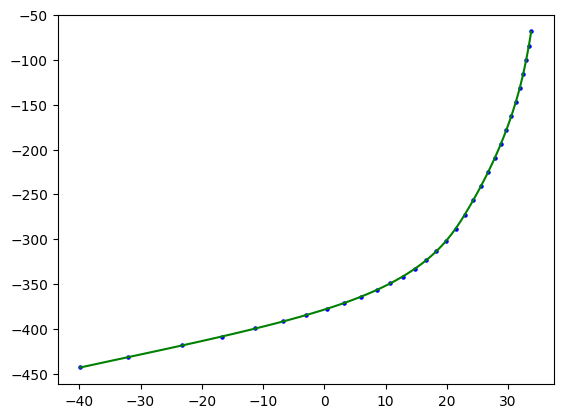

In [8]:
import os
import json

import numpy as np
from geomdl import fitting, BSpline, utilities
from matplotlib import pyplot as plt

data_fp = "\\\\192.168.29.222\\Share\\工程数据Q1\\objs\\仅工程类\\0306\\阙志华\\合体一片袖交叉门襟木耳边连衣裙"
pattern_fp = os.path.join(data_fp, 'pattern.json')

with open(pattern_fp, 'r', encoding='utf-8') as f: pattern_spec = json.load(f)

for panel in pattern_spec['panels']:
    origin = np.array(panel['center'])
    print(panel['id'], origin)
    
    for seq_edge in panel['seqEdges']:
        for edge in seq_edge['edges']:
            
            bezierPts = np.asarray(edge['bezierPoints'])[:, :2]
            ctrlPts = np.asarray(edge['controlPoints'])[:, :2]

            if np.any(bezierPts) and len(ctrlPts) == 2:
                if not np.any(bezierPts[1]):
                    # print('quadratic bezier')
                    bezierPts[1] = 2.0 / 3.0 * \
                        (bezierPts[0] + ctrlPts[0] - ctrlPts[1])
                    bezierPts[0] = 2.0 / 3.0 * bezierPts[0]

                bezierPts = ctrlPts + bezierPts
                curve = BSpline.Curve()
                curve.degree = 3
                curve.ctrlpts = [ctrlPts[0].tolist()] + \
                    bezierPts.tolist() + [ctrlPts[1].tolist()]
                curve.knotvector = utilities.generate_knot_vector(
                    curve.degree, len(curve.ctrlpts))
                curve.sample_size = 100
                curve.evaluate()

                line_color = 'r'
                evalpts = np.array(curve.evalpts)

            else:
                if ctrlPts.shape[0] <= 2:
                    evalpts = ctrlPts
                else:
                    curve = fitting.interpolate_curve(
                        ctrlPts.tolist(), degree=2 if ctrlPts.shape[0] < 5 else 3)
                    curve.sample_size = 100
                    curve.evaluate()
                    evalpts = np.array(curve.evalpts)
                    line_color = 'g'
            
            plt.plot(evalpts[:, 0], evalpts[:, 1], c=line_color)
            plt.scatter(ctrlPts[:, 0], ctrlPts[:, 1], s=5.0, c='b')
            
            break
        break
    break
                    

# 4. Visualization Scripts

## 4.1 Test Plotly visualization

In [ ]:
import os
import random
from glob import glob

import numpy as np
import pickle

import plotly.graph_objects as go

from matplotlib.colors import to_rgb


_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias": "橡筋", "color": "#696969"},
    "木耳边": {"alias": "木耳边", "color": "#A8D4D2"},
    "袖笼拼条": {"alias": "袖笼拼条", "color": "#696969"},
    "荷叶边": {"alias": "荷叶边", "color": "#A8D4D2"},
    "绑带": {"alias": "绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽', '领', '肩', '袖片', '袖口', '衣身前中', '衣身后中', '衣身侧', '底摆', '腰头', '裙前中', '裙后中', '裙侧', '橡筋', '木耳边', '袖笼拼条', '荷叶边', '绑带']

def create_bounding_box_lines(min_point, max_point, color):
    # Create the 12 lines of the bounding box
    x_lines = []
    y_lines = []
    z_lines = []
    
    # List of all 8 corners of the box
    x0, y0, z0 = min_point
    x1, y1, z1 = max_point

    corners = np.array([
        [x0, y0, z0],  # 0
        [x1, y0, z0],  # 1
        [x1, y1, z0],  # 2
        [x0, y1, z0],  # 3
        [x0, y0, z1],  # 4
        [x1, y0, z1],  # 5
        [x1, y1, z1],  # 6
        [x0, y1, z1]   # 7
    ])

    # Pairs of corners between which to draw lines
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
        (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
        (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
    ]

    for edge in edges:
        start = corners[edge[0]]
        end = corners[edge[1]]
        x_lines.extend([start[0], end[0], None])  # None to break the line
        y_lines.extend([start[1], end[1], None])
        z_lines.extend([start[2], end[2], None])

    line_trace = go.Scatter3d(
        x=x_lines,
        y=y_lines,
        z=z_lines,
        mode='lines',
        line=dict(color=color, width=5),
        showlegend=False
    )
    return line_trace

def create_bounding_box_mesh(min_point, max_point, color, opacity=0.2):
    # List of all 8 corners of the box
    x0, y0, z0 = min_point
    x1, y1, z1 = max_point

    corners = np.array([
        [x0, y0, z0],  # 0
        [x1, y0, z0],  # 1
        [x1, y1, z0],  # 2
        [x0, y1, z0],  # 3
        [x0, y0, z1],  # 4
        [x1, y0, z1],  # 5
        [x1, y1, z1],  # 6
        [x0, y1, z1]   # 7
    ])

    # Define the triangles composing the surfaces of the box
    # Each face is composed of two triangles
    faces = np.array([
        [0, 1, 2], [0, 2, 3],  # Bottom face
        [4, 5, 6], [4, 6, 7],  # Top face
        [0, 1, 5], [0, 5, 4],  # Side face
        [1, 2, 6], [1, 6, 5],  # Side face
        [2, 3, 7], [2, 7, 6],  # Side face
        [3, 0, 4], [3, 4, 7]   # Side face
    ])

    x = corners[:, 0]
    y = corners[:, 1]
    z = corners[:, 2]

    i = faces[:, 0]
    j = faces[:, 1]
    k = faces[:, 2]

    mesh = go.Mesh3d(
        x=x,
        y=y,
        z=z,
        i=i,
        j=j,
        k=k,
        color=color,
        opacity=opacity,
        name='Bounding Box',
        showlegend=False,
        flatshading=True
    )

    return mesh


def vis_bbox_plotly(bboxes, colors, points=None):
    fig = go.Figure()

    for idx in range(len(bboxes)):
        
        # visuzlize point clouds if given
        if points is not None:
            cur_points = points[idx].reshape(-1, 3)
            rand_idx = np.random.choice(cur_points.shape[0], 2000, replace=False)
            cur_points = cur_points[rand_idx, :]
            fig.add_trace(go.Scatter3d(
                x=cur_points[:, 0],
                y=cur_points[:, 1],
                z=cur_points[:, 2],
                mode='markers',
                marker=dict(size=2, color='#3e3e3e'),
                name=f'Point Cloud {idx+1}'
            ))
            
        # Add the bounding box lines
        min_point, max_point = bboxes[idx, :3], bboxes[idx, 3:]
        bbox_lines = create_bounding_box_lines(min_point, max_point, color=colors[idx])
        fig.add_trace(bbox_lines)
        # Add the bounding box surfaces with transparency
        bbox_mesh = create_bounding_box_mesh(min_point, max_point, color=colors[idx], opacity=0.15)
        fig.add_trace(bbox_mesh)

    # Update layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                visible=False,
                showbackground=False,
                showgrid=False,
                showline=False,
                showticklabels=False,
                title=''
            ),
            yaxis=dict(
                visible=False,
                showbackground=False,
                showgrid=False,
                showline=False,
                showticklabels=False,
                title=''
            ),
            zaxis=dict(
                visible=False,
                showbackground=False,
                showgrid=False,
                showline=False,
                showticklabels=False,
                title=''
            ),
            aspectmode='data'  # Keep the aspect ratio of data
        ),
        width=800,
        height=800,
        margin=dict(r=0, l=0, b=0, t=0),
        showlegend=False
    )
    fig.show()


# data_dir = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_reso_64_edge_snap"
# data_item = random.choice(glob(os.path.join(data_dir, '*.pkl')))
data_item = "E:\\lry\\data\\AIGP\\demo_v2\\Q2\\brep_reso_128_edge_snap\\00000.pkl"

print(data_item)
with open(data_item, 'rb') as f: data = pickle.load(f)

bboxes = data['surf_bbox_wcs']
bbox_colors = [_CMAP[_PANEL_CLS[idx-1]]['color'] for idx in data['surf_cls']]
points = data['surf_wcs']

# bboxes = np.random.rand(11, 6)
# bbox_colors = [_CMAP[_PANEL_CLS[idx-1]]['color'] for idx in np.random.randint(1, 18, 11)]

vis_bbox_plotly(bboxes, bbox_colors, points=points)


## 4.2 Bake Geometry Image

Prepare UV aligned normal visualization (for comparison with **3D generative models** Tripo/Rodin/Hunyuan).

In [ ]:
import json
import os
import sys
import numpy as np

import shutil

import torch
torch.set_grad_enabled(False)

import trimesh

import imageio
import numpy as np
import nvdiffrast.torch as dr

from glob import glob
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba

root_dir = 'E:\\lry\\code\\image2pattern'

sys.path.append(root_dir)
sys.path.append(os.path.join(root_dir, 'thirdparty'))

from garment_helper.obj_helper import read_obj

_CMAP = {
    "帽": {"alias": "帽", "color": "#F7815D"},
    "领": {"alias": "领", "color": "#F9D26D"},
    "肩": {"alias": "肩", "color": "#F23434"},
    "袖片": {"alias": "袖片", "color": "#C4DBBE"},
    "袖口": {"alias": "袖口", "color": "#F0EDA8"},
    "衣身前中": {"alias": "衣身前中", "color": "#8CA740"},
    "衣身后中": {"alias": "衣身后中", "color": "#4087A7"},
    "衣身侧": {"alias": "衣身侧", "color": "#DF7D7E"},
    "底摆": {"alias": "底摆", "color": "#DACBBD"},
    "腰头": {"alias": "腰头", "color": "#DABDD1"},
    "裙前中": {"alias": "裙前中", "color": "#46B974"},
    "裙后中": {"alias": "裙后中", "color": "#6B68F5"},
    "裙侧": {"alias": "裙侧", "color": "#D37F50"},

    "橡筋": {"alias":"橡筋", "color": "#696969"},
    "木耳边": {"alias":"木耳边", "color": "#696969"},
    "袖笼拼条": {"alias":"袖笼拼条", "color": "#696969"},
    "荷叶边": {"alias":"荷叶边", "color": "#696969"},
    "绑带": {"alias":"绑带", "color": "#696969"}
}

_PANEL_CLS = [
    '帽','领','肩','袖片','袖口','衣身前中','衣身后中','衣身侧','底摆','腰头','裙前中','裙后中','裙侧','橡筋','木耳边','袖笼拼条','荷叶边','绑带']
# _PANEL_COLORS = torch.tensor(
#     [to_rgba(_CMAP[_PANEL_CLS[idx]]['color']) for idx in range(len(_PANEL_CLS))],
#     device='cuda', dtype=torch.float32, requires_grad=False)

_PANEL_COLORS = np.array(
    [(0., 0., 0., 0.)] + [to_rgba(_CMAP[_PANEL_CLS[idx]]['color']) for idx in range(len(_PANEL_CLS))]
)

def interpolate_feature_dr(rast, pos, tris, feat, transparent=False):
    # print('*** interpolate_feature_dr: ', feat.shape, rast.shape, pos.shape, tris.shape)
    
    if rast.dim() == 4 and rast.shape[0] == 1: feat, pos = feat[None], pos[None]
    out, _ = dr.interpolate(feat, rast, tris)
    out = dr.antialias(out, rast, pos, tris)    

    print('*** out: ', out.shape, out.min(), out.max(), '*** rast: ', rast.shape)
    if transparent: out = torch.cat([out, rast[..., 3:]], dim=-1)

    out = out.detach().cpu().numpy()[:, ::-1, :, :]    

    # for idx in range(out.shape[0]):
    #     plt.imshow(out[idx])
    #     plt.show()
        
    return out

    
def render_mesh_uv_general(
    glctx,
    mesh_fp,
    out_dir='',
    img_wh = (2048, 2048)
):
    try:
        mesh_obj = trimesh.load(mesh_fp, force='mesh')
        verts = torch.tensor(mesh_obj.vertices, dtype=torch.float32).cuda()
        tris = torch.tensor(mesh_obj.faces, dtype=torch.int32).cuda()
        uv = torch.tensor(mesh_obj.visual.uv, dtype=torch.float32).cuda() * 2.0 - 1.0
        normals = torch.tensor(mesh_obj.vertex_normals, dtype=torch.float32).cuda()
        print(verts.shape, tris.shape, uv.shape, normals.shape)
    except Exception as e:
        mesh_obj = read_obj(mesh_fp)
        verts = torch.from_numpy(mesh_obj.points).to(torch.float32).to('cuda')
        uv = torch.from_numpy(mesh_obj.point_data['obj:vt']).to(torch.float32).to('cuda')
        normals = torch.from_numpy(mesh_obj.point_data['obj:vn']).to(torch.float32).to('cuda')
        print(verts.shape, tris.shape, uv.shape, normals.shape)

    bbox_3d = (
        torch.min(verts, axis=0, keepdim=True)[0],
        torch.max(verts, axis=0, keepdim=True)[0]
    )
    verts_offset = (bbox_3d[0] + bbox_3d[1]) * 0.5
    verts_scale = max(bbox_3d[1] - bbox_3d[0]) * 0.5
    verts = (verts - verts_offset) / verts_scale

    render_uv = torch.cat([
        uv, 
        torch.zeros_like(uv[:, :1], dtype=torch.float32, device='cuda'),
        torch.ones_like(uv[:, :1], dtype=torch.float32, device='cuda')
        ], dim=-1)

    print("*** render_uv: ", render_uv.shape, render_uv.min(), render_uv.max())
    rast, _ = dr.rasterize(
        glctx, render_uv[None], tris, resolution=[int(img_wh[1]), int(img_wh[0])])
    
    out = interpolate_feature_dr(rast, render_uv, tris, (verts + 1.0) * 0.5, transparent=True)
    print('*** out: ', out.shape, out.min(), out.max(), '*** rast: ', rast.shape)

    print('*** normals: ', normals.shape, normals.min(), normals.max(), normals.is_contiguous())
    out_nrm = interpolate_feature_dr(rast, render_uv, tris, (normals.contiguous() + 1.0) * 0.5, transparent=True)
    print('*** out_nrm: ', out_nrm.shape, out_nrm.min(), out_nrm.max(), '*** rast: ', rast.shape)

    if out_dir:
        imageio.imsave(
            os.path.join(out_dir, 'geo.png'), 
            np.clip(np.rint(out[0] * 255), 0, 255).astype(np.uint8))
        imageio.imsave(
            os.path.join(out_dir, 'nrm.png'),
            np.clip(np.rint(out_nrm[0] * 255), 0, 255).astype(np.uint8))

    return out, out_nrm



def render_mesh_uv_aigp(
    glctx, 
    data_dir, 
    out_dir='', 
    render_scale=1.0, 
    use_global_bbox=False, 
    seperate_by_panel=False,
    render_uv=True,           # render 2D relative coordinate
    render_seg=False           # render pattern semantics
    ):    
    mesh_fp = os.path.join(data_dir, os.path.basename(data_dir)+'.obj')
    pattern_fp = os.path.join(data_dir, 'pattern.json')

    # load 3D mesh
    mesh_obj = read_obj(mesh_fp)
    
    # load 2D panel
    with open(pattern_fp, 'r', encoding='utf-8') as f: pattern_data = json.load(f)
    panel_data = dict([(x['id'], x) for x in pattern_data['panels']])
    
    if use_global_bbox:
        avatar_fp = os.path.dirname(mesh_fp) + '\\avatar.json'
        with open(avatar_fp, 'r') as f: avatar_data = json.load(f)
        arrange_pts = torch.tensor([x['xyz'] for x in avatar_data[0]['arrangements']], dtype=torch.float32, device='cuda')
        global_bbox = torch.cat([torch.min(arrange_pts, axis=0, keepdim=True)[0], torch.max(arrange_pts, axis=0, keepdim=True)[0]], dim=0)
    
    verts = torch.from_numpy(mesh_obj.points).to(torch.float32).to('cuda')
    uv = torch.from_numpy(mesh_obj.point_data['obj:vt']).to(torch.float32).to('cuda')
    normals = torch.from_numpy(mesh_obj.point_data['obj:vn']).to(torch.float32).to('cuda')
    
    # relataive coordinate to its belonging panel
    if render_uv or seperate_by_panel: uv_local = uv.clone()
    verts_local = verts.clone()

    bbox_2d = torch.cat([
        torch.min(uv[:, :2], axis=0, keepdim=True)[0] - 10.0, 
        torch.max(uv[:, :2], axis=0, keepdim=True)[0] + 10.0
        ])
    
    img_wh = bbox_2d[1] - bbox_2d[0]
    
    panel_ids = []
    tris = []                           # all triangles
    if render_seg: tri_semantics = []   # triangle semantics
    
    if seperate_by_panel: 
        tri_ranges = []         # triangle range for each panel, 
        start_idx = 0
                
    for idx, panel_id in enumerate(mesh_obj.field_data['obj:group_tags']):
        panel_faces = mesh_obj.cells[idx].data
        vert_ids = np.unique(panel_faces)        
        
        # normalize to [0, 1]
        if use_global_bbox:
            verts_local[vert_ids, :] = (verts_local[vert_ids, :] - global_bbox[0]) / (global_bbox[1] - global_bbox[0]) 
        else:
            panel_bbox = torch.cat([
                torch.min(verts_local[vert_ids, :], dim=0, keepdim=True)[0], 
                torch.max(verts_local[vert_ids, :], dim=0, keepdim=True)[0]
                ])
            verts_local[vert_ids, :] = (verts_local[vert_ids, :] - panel_bbox[0]) / (panel_bbox[1] - panel_bbox[0]) 
        
        if seperate_by_panel: 
            tri_ranges.append([start_idx, len(panel_faces)])
            start_idx += len(panel_faces)

        tris.append(torch.from_numpy(panel_faces).to('cuda'))
        panel_ids.append(torch.ones_like(tris[-1][:, 0], dtype=torch.int32, device='cuda') * idx)
        
        if render_seg:
            panel_seg_id = panel_data[panel_id]['label'].strip()
            panel_seg_id = _PANEL_CLS.index(panel_seg_id) + 1 if panel_seg_id in _PANEL_CLS else 0.
            tri_semantics.append(torch.ones_like(tris[-1][:, 0], dtype=torch.int32, device='cuda') * panel_seg_id)
        
        if render_uv or seperate_by_panel:
            panel_center = torch.tensor(panel_data[panel_id]['center'], device='cuda')[None]
            panel_uv = uv_local[vert_ids, :] - panel_center[:2]
            panel_bbox = (
                torch.min(panel_uv, dim=0, keepdim=True)[0],
                torch.max(panel_uv, dim=0, keepdim=True)[0]
            )
            panel_uv = (panel_uv - panel_bbox[0]) / (panel_bbox[1] - panel_bbox[0] + 1e-6)      # normalize to [0, 1]
            uv_local[vert_ids, :] = panel_uv
                
    panel_ids = torch.cat(panel_ids, dim=0)
    tris = torch.cat(tris, dim=0)
                
    if seperate_by_panel:
        tri_ranges = torch.tensor(tri_ranges, dtype=torch.int32) # panel triangle range#
     
    pos = (uv[:, :2] - bbox_2d[0, :] + 1e-6) / (bbox_2d[1, :] - bbox_2d[0, :] + 1e-6) * 2.0 - 1.0
    print("*** pos: ", pos.shape, pos.min(), pos.max())
    pos = torch.cat([
        pos, 
        torch.zeros_like(pos[:, :1], dtype=torch.float32, device='cuda'),
        torch.ones_like(pos[:, :1], dtype=torch.float32, device='cuda')
        ], dim=1)
     
    render_scale = min(render_scale, 2048.0 / max(img_wh))
    img_wh = (img_wh * render_scale / 8).ceil() * 8 
 
    if seperate_by_panel:
        uv_local = uv_local[..., :2] * 2.0 - 1.0
        uv_local = torch.cat([
            uv_local, 
            torch.zeros_like(uv_local[:, :1]),
            torch.ones_like(uv_local[:, :1])], dim=1)
        rast, _ = dr.rasterize(
            glctx, uv_local, tris, resolution=[512, 512], ranges=tri_ranges)
        out = interpolate_feature_dr(rast, uv_local, tris, verts_local)
        out_uv = interpolate_feature_dr(rast, uv_local, tris, uv_local) if render_uv else None
    else:

        print("*** render pos: ", pos.shape, pos.min(), pos.max())
        print('*** tris: ', tris.shape, tris.min(), tris.max())

        rast, _ = dr.rasterize(
            glctx, pos[None], tris, resolution=[int(img_wh[1]), int(img_wh[0])])
        out = interpolate_feature_dr(rast, pos, tris, verts_local, transparent=True)
        print('*** normals: ', normals.shape, normals.min(), normals.max())
        out_nrm = interpolate_feature_dr(rast, pos, tris, (normals + 1.0)*0.5, transparent=True)
        out_uv = interpolate_feature_dr(rast, pos, tris, uv_local, transparent=True) if render_uv else None

        print('*** out_nrm: ', out_nrm.shape, out_nrm.min(), out_nrm.max(), '*** rast: ', rast.shape)
                
    if render_seg:
        tri_semantics = torch.cat([torch.zeros_like(tri_semantics[0][:1])] + tri_semantics, dim=0).long().detach().cpu().numpy()
        tri_index = rast[..., 3][0].long().detach().cpu().numpy()
        out_seg = tri_semantics[tri_index][::-1, :]
                
    if out_dir:
        # shutil.copyfile(mesh_fp, os.path.join(out_dir, os.path.basename(out_dir)+'.obj'))
        shutil.copyfile(pattern_fp, os.path.join(out_dir, 'pattern.json'))
        if seperate_by_panel: np.save(os.path.join(out_dir, 'geo.npy'), out*2.0-1.0)
        
        else:
            imageio.imsave(
                os.path.join(out_dir, 'geo.png'), 
                np.clip(np.rint(out[0] * 255), 0, 255).astype(np.uint8))
            imageio.imsave(
                os.path.join(out_dir, 'nrm.png'),
                np.clip(np.rint(out_nrm[0] * 255), 0, 255).astype(np.uint8))
            if render_uv: 
                imageio.imsave(
                    os.path.join(out_dir, 'uv.png'),
                    np.clip(np.rint(out_uv[0] * 255), 0, 255).astype(np.uint8))
            if render_seg:
                np.save(os.path.join(out_dir, 'seg.npy'), out_seg)
                imageio.imsave(
                    os.path.join(out_dir, 'seg.png'),
                    np.clip(np.rint(_PANEL_COLORS[out_seg, :] * 255), 0, 255).astype(np.uint8)
                )

    return out, out_uv, out_seg


glctx = dr.RasterizeCudaContext()

# ################### Test Render AIGP ###################
data_root = "C:\\Users\\llinctex\\Desktop\\images\\GarmageNet\\objs"
data_root = "C:\\Users\\llinctex\\Desktop\\images\\Design2GarmentCode\\06_00196"
# for data_id in os.listdir(data_root):
for data_id in [data_root]:
    if not os.path.isdir(os.path.join(data_root, data_id)): continue
    data_dir = os.path.join(data_root, data_id)
    output_dir = os.path.join(data_dir, '..', f'{data_id}_uv_vis')
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        out, _, _ = render_mesh_uv_aigp(
            glctx, data_dir, output_dir, 
            use_global_bbox=True, seperate_by_panel=False, 
            render_uv=False, render_seg=True
            )

    print('[DONE] ', data_id) 




# # ################### Test Render General ###################

# data_root = "C:\\Users\\llinctex\\Desktop\\images\\T3D"
# all_items = glob(os.path.join(data_root, '**', '*.obj'), recursive=True)

# # import zipfile
# # for data_item in all_items:
# #     with zipfile.ZipFile(data_item, 'r') as zip_ref:
# #         zip_ref.extractall(data_root)
# #         shutil.move(os.path.join(data_root, 'base.obj'), data_item.replace('.zip', '.obj'))

# for data_item in all_items:
#     output_dir = data_item.replace('.obj', '_uv_vis')
#     os.makedirs(output_dir, exist_ok=True)
    
#     with torch.no_grad():
#         out, out_nrm = render_mesh_uv_general(glctx, data_item, output_dir)
#         shutil.copyfile(data_item, os.path.join(output_dir, os.path.basename(data_item)))


# ################### Test Render AIGP ###################
# data_item = "..\\examples\\objs\\0000"
# output_dir = "..\\examples\\objs\\0000\\uv_vis"
# os.makedirs(output_dir, exist_ok=True)

# glctx = dr.RasterizeCudaContext()

# with torch.no_grad():
#     out, _, _ = render_mesh_uv_aigp(

#         glctx, data_item, output_dir, 
#         use_global_bbox=True, seperate_by_panel=False, 
#         render_uv=False, render_seg=True) 
    


# # # ################### Test Render General ###################
# # data_item = "..\\examples\\objs\\tripo_convert_8c7f994e-52ef-4d8a-90a3-4abbeb8c0b31"
# # output_dir = "..\\examples\\objs\\tripo_convert_8c7f994e-52ef-4d8a-90a3-4abbeb8c0b31\\uv_vis"
# mesh_fp = "E:\\lry\\work\\Research\\stylexd_gen\\results\\用来做comparision的\\garment_01_00012\\text\\hyper3d\\base.obj"
# output_dir = "E:\\lry\\work\\Research\\stylexd_gen\\results\\用来做comparision的\\garment_01_00012\\text\\hyper3d\\uv_vis"
# os.makedirs(output_dir, exist_ok=True)

# glctx = dr.RasterizeCudaContext()

# with torch.no_grad():
#     out, out_nrm = render_mesh_uv_general(glctx, mesh_fp, output_dir)